In [1]:
from extract.extract import getTLEsFromLaunches, getCredentials
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# import sklearn
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
from sklearn.utils import shuffle

import xgboost as xgb

start = datetime(2016, 1, 1)
end = datetime(2023, 1, 1)

token = getCredentials(source="discos")
username, password = getCredentials(source="spacetrack")

launchIDs = ["2013-066", "2018-092", "2019-084", "2022-002"]
launchIDs = ["2013-066", "2018-092", "2019-084", "2022-002", "2021-006"]
# launchIDs = ["2013-066"]
# launchIDs = ["2022-002"]
# launchIDs = ["2019-084"]
ignoreList = [44827, 44828, 44829, 44830, 44831, 44832] + [39435, 39436, 39437] + [43704, 44046]
# combining everything into one DF
discosDataDict, dfOriginal = getTLEsFromLaunches(
    username,
    password,
    token,
    launchIDs,
    start,
    end,
    combineDiscosAndTLE=True,
    collectLaunches=True,
    collectAllTLEs=True,
    forceRegen=False,
    ignoreList=ignoreList
)


Launch: 2013-066: 100%|██████████| 28/28 [00:03<00:00,  8.54it/s]


Skipped NORADid 39435
Skipped NORADid 39436
Skipped NORADid 39437


Launch: 2018-092: 100%|██████████| 4/4 [00:00<00:00, 14.93it/s]


Skipped NORADid 43704
Skipped NORADid 44046


Launch: 2019-084: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Skipped NORADid 44827
Skipped NORADid 44828
Skipped NORADid 44829
Skipped NORADid 44830
Skipped NORADid 44831
Skipped NORADid 44832


Launch: 2021-006: 100%|██████████| 143/143 [00:05<00:00, 25.17it/s]


In [105]:
# print(dfOriginal.columns)
print(f"original length: {len(dfOriginal)}")
df = dfOriginal.query("overallCovariance < 5")#.query("RCS_SIZE == 'SMALL'")
print(f"reduced length: {len(df)}")

colsToDrop = [
       'vimpelId', 'OBJECT_NAME', 'CENTER_NAME',
       'MEAN_MOTION', 'RA_OF_ASC_NODE',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'NORAD_CAT_ID', 'ELEMENT_SET_NO',
       'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT',
        'PERIOD', 'COUNTRY_CODE', 'LAUNCH_DATE', 'DECAY_DATE', 'TLE_LINE0', "OBJECT_TYPE", "objectClass", 
       'TLE_LINE1', 'TLE_LINE2', 'TLE_LINE1min1', 'TLE_LINE2min1']

df = df.drop(colsToDrop, axis=1)


print(df.groupby("shape").size())

print(df.satname.unique())

original length: 473898
reduced length: 466872
shape
Box                             174066
Box + 1 Ant                      10406
Box + 1 Pan                      18678
Box + 1 Pan + 1 Dish + 1 Rod      4154
Box + 1 Rod                       9992
Box + 2 Ant                      54583
Box + 2 Pan                     168823
Box + 2 Pan + 1 Dish               646
Box + 4 Pan                      13412
Cyl                               1470
Hex Cyl + 2 Pan + 1 Dish          2399
Hex Cyl + 3 Pan                   8243
dtype: int64


### Create ML dataset

In [106]:
# Get ML dataset
colsToDrop = ["name", "cosparId", "shape", "diameter", "EPOCH", "satno"]
colsToDrop2 = ["ECCENTRICITY", "INCLINATION", "PERIAPSIS", "APOAPSIS", "SEMIMAJOR_AXIS", "deltat"]
colsToDrop3 = ['height', "width", "depth", 'xSectAvg']     
labels = ["errorX", "errorY", "errorZ", "errorCross", "errorAlong", "errorRadial", "overallCovariance", "overallVelocityCovariance", "actualX", "actualY", "actualZ"]

# dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop2, axis=1)
dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop3, axis=1).drop(colsToDrop2, axis=1)
# dfML = df.drop(colsToDrop, axis=1).drop(colsToDrop3, axis=1)
# dfML = df.drop(colsToDrop, axis=1)
print(df.columns)
# print(df.head())
print("nan analyiss")
# print(dfFeatures.describe())
print("With NaN", len(df))
dfML = dfML.dropna()
print("Without NaN", len(df))
print("nan analyiss")
# dfLabels = dfML[["errorCross", "errorAlong", "errorRadial"]]
# dfLabels = dfML[["errorAlong"]]
# dfLabels = dfML[["overallCovariance"]]
dfLabels = dfML[["errorX", "errorY", "errorZ"]]
# dfLabels = dfML[["actualX", "actualY", "actualZ"]]
dfFeatures = dfML.drop(labels, axis=1)


# print(dfML.head())
print(dfFeatures.RCS_SIZE.unique())
print(dfFeatures.groupby("RCS_SIZE").size())

# encode RCS_SIZE
# encoding = [[value, idx] for idx, value in enumerate(dfML.RCS_SIZE.unique())]
cats = list(dfFeatures.RCS_SIZE.unique())
enc_RCS_SIZE = LabelEncoder()
enc_RCS_SIZE.fit(dfFeatures.RCS_SIZE)
dfFeatures.RCS_SIZE = enc_RCS_SIZE.transform(dfFeatures.RCS_SIZE)
# print(dfFeatures)

columnsFeatures = list(dfFeatures.columns)
columnsLabels = list(dfLabels.columns)

scalerX = RobustScaler()
scalerY = RobustScaler()

scalerX.fit(dfFeatures)
X = scalerX.transform(dfFeatures)

# scalerY.fit(dfLabels)
# y = scalerY.transform(dfLabels)[:, 0]
y=dfLabels.to_numpy()

print(y.shape)

Index(['depth', 'name', 'cosparId', 'xSectAvg', 'shape', 'width', 'xSectMax',
       'height', 'diameter', 'xSectMin', 'mass', 'span', 'satno', 'antennas',
       'pannels', 'rods', 'volume', 'EPOCH', 'ECCENTRICITY', 'INCLINATION',
       'SEMIMAJOR_AXIS', 'APOAPSIS', 'PERIAPSIS', 'RCS_SIZE', 'deltat',
       'errorX', 'errorY', 'errorZ', 'errorCross', 'errorAlong', 'errorRadial',
       'overallCovariance', 'overallVelocityCovariance', 'simX', 'simY',
       'simZ', 'actualX', 'actualY', 'actualZ'],
      dtype='object')
nan analyiss
With NaN 466872
Without NaN 466872
nan analyiss
['MEDIUM' 'SMALL' 'LARGE']
RCS_SIZE
LARGE      12564
MEDIUM    154144
SMALL     235054
dtype: int64
(401762, 3)


Remember: Size is unbalanced

### Shuffling/splitting

In [107]:
X_train, X_test, y_train, y_test, _, y_dfML= train_test_split(X, y, dfML, test_size=0.1, random_state=42)
# print(shuffle(y, random_state=42)[361585::, :]-y_test)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

361585 361585
40177 40177


### Models

In [108]:
print("Training Random Forest")
RndmFrst = RandomForestRegressor(verbose=1, n_jobs=11, n_estimators=100, max_depth=20, min_samples_split=2, max_features="log2")
RndmFrst.fit(X_train, y_train,) # sample_weight=y_train**(1/3))

y_predict_RF = RndmFrst.predict(X_test)


Training Random Forest


[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:   10.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:   33.1s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.3s finished


In [109]:
print("Training Gradient Boosting Machine")
# GBreg = GradientBoostingRegressor(verbose=1, n_estimators=100)
# # GBreg = SVR(verbose=1)
# GBreg.fit(X_train, y_train)

# y_predict_GBM = GBreg.predict(X_test)
# xg_reg = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     colsample_bytree=0.3,
#     learning_rate=0.1,
#     max_depth=5,
#     alpha=10,
#     n_estimators=100,
# )
xg_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    # colsample_bytree=0.2,
    learning_rate=0.1,
    verbosity=1,
    max_depth=10,
    alpha=5,  
    n_estimators=100,
)
xg_reg.fit(X_train, y_train)
y_predict_GBM = xg_reg.predict(X_test)


Training Gradient Boosting Machine


In [110]:
xg_reg.save_model("xgb1.json")

### Compare

(40177, 23)
Random Forest  | MSE = 0.09281378036622823, MAE = 0.08808865341472173, R2-score = 0.7601873080020087
Gradient Boost | MSE = 0.0843455454043817, MAE = 0.07341473828028829, R2-score = 0.7820675742152665


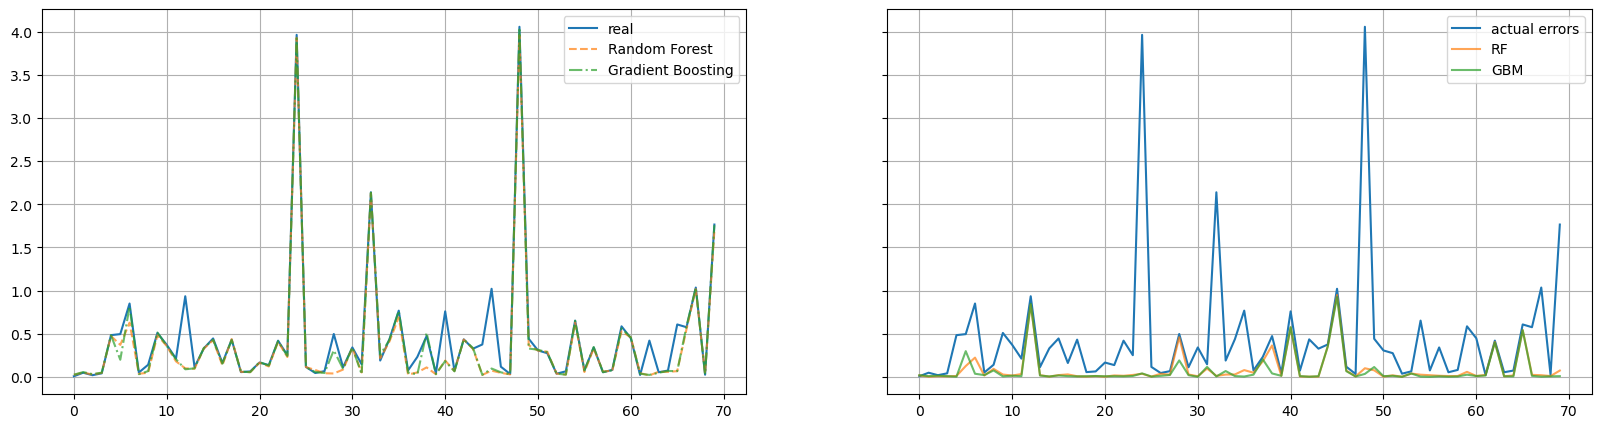

In [111]:
# transform back
# print(y_predict.shape)

y_predict_RF_inv = np.sqrt(np.square(y_predict_RF).sum(axis=1))
y_predict_GMB_inv = np.sqrt(np.square(y_predict_GBM).sum(axis=1))
y_test_inv = np.sqrt(np.square(y_test).sum(axis=1))

# y_predict_RF_inv = y_predict_RF
# y_predict_GMB_inv = y_predict_GBM
# y_test_inv = y_test

# y_predict_RF_inv = scalerY.inverse_transform(y_predict_RF[:, np.newaxis])
# y_predict_GMB_inv = scalerY.inverse_transform(y_predict_GBM[:, np.newaxis])
# y_test_inv = scalerY.inverse_transform(y_test[:, np.newaxis])

MSE_RF = mean_squared_error(y_test_inv, y_predict_RF_inv)
MAE_RF = mean_absolute_error(y_test_inv, y_predict_RF_inv)
R2_RF = r2_score(y_test_inv, y_predict_RF_inv)

MSE_GBM = mean_squared_error(y_test_inv, y_predict_GMB_inv)
MAE_GBM = mean_absolute_error(y_test_inv, y_predict_GMB_inv)
R2_GBM = r2_score(y_test_inv, y_predict_GMB_inv)


fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True)
sampleStart = 700
sampleSize = 70
feat = 0
print(y_dfML.shape)
errorsOrig = pd.DataFrame(y_dfML, columns=dfML.columns).overallCovariance.to_numpy()

ax[0].plot(y_test_inv[sampleStart:(sampleStart + sampleSize)], label="real")
ax[0].plot(y_predict_RF_inv[sampleStart:(sampleStart + sampleSize)], linestyle="--", label="Random Forest", alpha=0.7)
ax[0].plot(y_predict_GMB_inv[sampleStart:(sampleStart + sampleSize)], linestyle="-.", label="Gradient Boosting", alpha=0.7)

ax[1].plot(errorsOrig[sampleStart:(sampleStart + sampleSize)], label="actual errors")
ax[1].plot(np.abs(y_test_inv[sampleStart:(sampleStart + sampleSize)] - y_predict_RF_inv[sampleStart:(sampleStart + sampleSize)]), label="RF", alpha=0.7)
ax[1].plot(np.abs(y_test_inv[sampleStart:(sampleStart + sampleSize)] - y_predict_GMB_inv[sampleStart:(sampleStart + sampleSize)]), label="GBM", alpha=0.7)

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

print(f"Random Forest  | MSE = {MSE_RF}, MAE = {MAE_RF}, R2-score = {R2_RF}")
print(f"Gradient Boost | MSE = {MSE_GBM}, MAE = {MAE_GBM}, R2-score = {R2_GBM}")


#### Check overfitting

Random Forest TRAINING DATA | MSE = 0.026850834196053174, MAE = 0.04559164365762594, R2-score = 0.5812905071922193


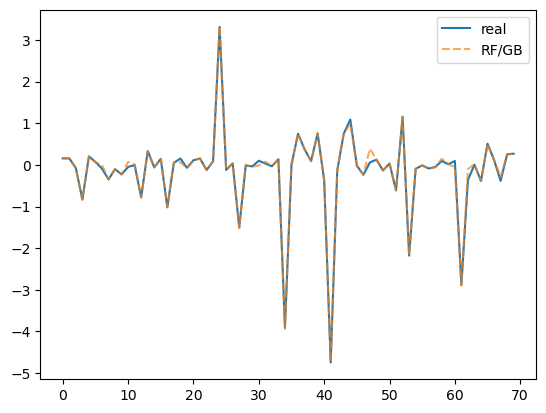

In [112]:

# yprTRAIN = RndmFrst.predict(X_train)
yprTRAIN = xg_reg.predict(X_train)
# yprTRAIN = scalerY.inverse_transform(yprTRAIN[:, np.newaxis])
# yTRAIN = scalerY.inverse_transform(y_train[:, np.newaxis])
yTRAIN = y_train
# yPr = scalerY.inverse_transform(y_predict_GBM[:, np.newaxis])
MSE_TRAIN = mean_squared_error(yTRAIN, yprTRAIN)
MAE_TRAIN = mean_absolute_error(yTRAIN, yprTRAIN)
R2_TRAIN = r2_score(yTRAIN, yprTRAIN)

print(f"Random Forest TRAINING DATA | MSE = {MSE_TRAIN}, MAE = {MAE_TRAIN}, R2-score = {R2_TRAIN}")

fig, ax = plt.subplots(1, 1)
sampleStart = 300
sampleSize = 70
feat = 2
ax.plot(yTRAIN[sampleStart:(sampleStart + sampleSize), feat], label="real")
ax.plot(yprTRAIN[sampleStart:(sampleStart + sampleSize), feat], linestyle="--", label="RF/GB", alpha=0.7)
# ax.plot(y_predict_GMB_inv[sampleStart:(sampleStart + sampleSize)], linestyle="--", label="Gradient Boosting", alpha=0.7)
ax.legend()

### Feature importances RF

xSectMax    0.006893
xSectMin    0.006753
mass        0.007113
span        0.011190
antennas    0.000388
pannels     0.003508
rods        0.000328
volume      0.006395
RCS_SIZE    0.003160
simX        0.074718
simY        0.070796
simZ        0.808759
dtype: float64


<AxesSubplot: >

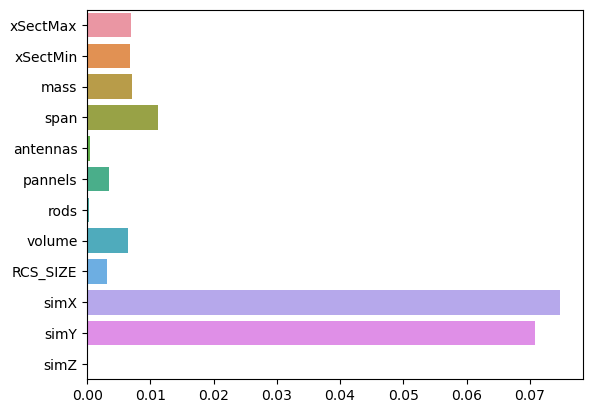

In [113]:
importances = RndmFrst.feature_importances_
forest_importances = pd.Series(importances, index=columnsFeatures)
print(forest_importances)
forest_importances["simZ"] = 0

std = np.std([tree.feature_importances_ for tree in RndmFrst.estimators_], axis=0)

sns.barplot(x = forest_importances, y=columnsFeatures, orient="h")

#### Importances XGBoost

xSectMax    0.024211
xSectMin    0.017629
mass        0.021724
span        0.028630
antennas    0.000071
pannels     0.023126
rods        0.002967
volume      0.008407
RCS_SIZE    0.013969
simX        0.021742
simY        0.021960
simZ        0.815564
dtype: float32


<AxesSubplot: >

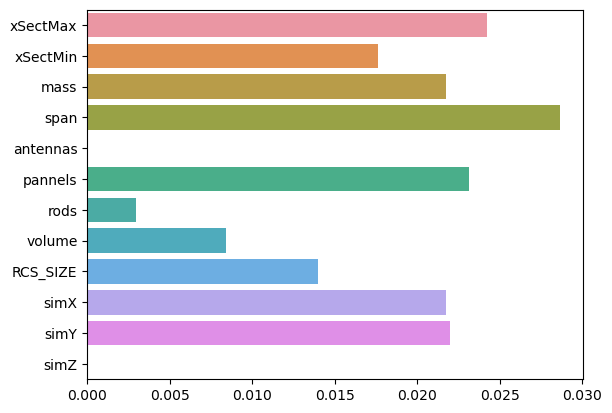

In [114]:
importances = xg_reg.feature_importances_
forest_importances = pd.Series(importances, index=columnsFeatures)
print(forest_importances)
forest_importances["simZ"] = 0
std = np.std([tree.feature_importances_ for tree in RndmFrst.estimators_], axis=0)

sns.barplot(x = forest_importances, y=columnsFeatures, orient="h")